# A guide from beginning to end to analyse kHz QPOs with stingray

## From an RXTE observation of the Neutron Star Low Mass X-ray Binary 4U 1636-53

### Author: Evandro M. Ribeiro ([evandromr.github.io](https://evandromr.github.io))
#### Date 23 March 2018


---

# 1- Donwloading and extracting observation files

This section Download the sample observations from NASA's archives and extracts using pythons builtin libraries `ftplib` `tarfile` and `os`

In [3]:
#!/usr/bin/env python
# -*- coding: UTF-8 -*-
"""A simple tool to download an RXTE observation from the HEASARC archive
   Author: Evandro M. Ribeiro <ribeiro .at. astro.rug.nl>
   Last updated: 18 Nov 2015 by Author
"""
from ftplib import FTP

def download_xte_obs(obsid, user='anonymous', passwd='anonymous@server.com'):
    """
    download_xte_obs(obsid, user='anonymous', passwd='anonymous@server.com')

    Download a RXTE observation from HEASARC archive via FTP
    The function identifies the location of the observation's files by the 
    number of the obseration ID and download all the files as a compressed
    *tar.gz file

    Parameters
    ----------
    obsid: str
        Observation ID to download
    user: str, optional
        User name for ftp connection. default is 'anonymous'
    passwd: str, optional
        Password for ftp connection. default is 'anonymous@server.com'

    Returns
    -------
    None: None

    Notes
    -----
    The observation will be saved as  <obsid>.tar.gz file in the current directory

    The default password is a dummy e-mail adress, HEASARC asks users to use their
    own e-mail as password, please provide your real e-mail when downloading. (See examples below).

    Examples
    --------
    1. - With username and password
    
    >>> obsid = '95081-02-56-98'
    >>> my_user = 'username'
    >>> my_password = '1234'
    >>> download_xte_obs(obsid, my_user, my_password)

    2. - Downloading as anonymous
         Username is `anonymous` by default, your e-mail is the password
   
    >>> from get_xte_obs import download_xte_obs
    >>> obsid = '95081-02-56-98'
    >>> my_password = 'username@mail.com'
    >>> download_xte_obs(obsid, passwd=my_password)

    """

    pid = obsid[:5]
    # Calculates AO number according to obsid
    if int(pid[:2]) < 90:
        ao = 'AO'+pid[0]
    else:
        ao = 'AO'+str(int(pid[1])+9)

    # P-id of the observation according to obsid
    pid = 'P'+pid

    # obsid to download as a tar.gz file
    tarfile = obsid+'.tar.gz'

    # start  FTP connection
    ftp = FTP('heasarc.gsfc.nasa.gov')
    ftp.login(user, passwd)

    # set debug level to moderate
    ftp.set_debuglevel(1)

    # path to obsid
    path = "/xte/data/archive/"+ao+"/"+pid

    # move to folder
    ftp.cwd(path)

    print('Attempting to download file {0}'.format(path+'/'+tarfile))
    print('Please Wait... This could take long depending on the download')

    # get file
    ftp.retrbinary('RETR {0}'.format(tarfile), open(tarfile, 'wb').write)
    print('File {0} Sucessfully downloaded'.format(tarfile))

    # quit FTP connection
    ftp.quit()

In [4]:
obsid = '92023-01-52-10'
my_user = 'anonymous'
my_password = 'ribeiro@astro.rug.nl'
download_xte_obs(obsid, my_user, my_password)

*cmd* 'CWD /xte/data/archive/AO11/P92023'
*resp* '250 CWD command successful'
Attempting to download file /xte/data/archive/AO11/P92023/92023-01-52-10.tar.gz
Please Wait... This could take long depending on the download
*cmd* 'TYPE I'
*resp* '200 Type set to I'
*cmd* 'PASV'
*resp* '227 Entering Passive Mode (129,164,179,23,231,169)'
*cmd* 'RETR 92023-01-52-10.tar.gz'
*resp* '150 Opening BINARY mode data connection for /FTP/mod_tar/DOOq1Z (25690112 bytes)'
*resp* '226 Transfer complete'
File 92023-01-52-10.tar.gz Sucessfully downloaded
*cmd* 'QUIT'
*resp* '221 Goodbye.'


In [25]:
ls *tar.gz

92023-01-52-10.tar.gz


In [26]:
import tarfile
tar = tarfile.open("92023-01-52-10.tar.gz")
tar.extractall()
tar.close()

In [32]:
import os

In [28]:
os.chdir("92023-01-52-10")

In [29]:
ls

ace/                    FIFD_186d5c45-186d62d8  gsace/
acs/                    FIGS_186d5c45-186d62d8  hexte/
cal/                    FIHX_186d5c45-186d62d8  ifog/
clock/                  FIIG_186d5c45-186d62d8  ipsdu/
eds/                    FIIP_186d5c45-186d62d8  orbit/
fds/                    FIOE_186d5c45-186d62d8  pca/
FIAC_186d5c45-186d62d8  FIPC_186d5c45-186d62d8  pse/
FIAE_186d5c45-186d62d8  FIPS_186d5c45-186d62d8  spsdu/
FICA_00000000-21e17c86  FISP_186d5c45-186d62d8  stdprod/
FICC_186d5c45-186d62d8  FIST_186d5c45-186d62d8
FIED_186d5c45-186d62d8  FMI


In [33]:
os.chdir("pca")

In [34]:
ls

FH5a_186d5c45-186d62e0.gz  FS37_186d5c45-186d62d1.gz
FH5b_186d5c45-186d62e0.gz  FS46_186d5c45-186d62d8.gz
FH5c_186d5c45-186d62e0.gz  FS4a_186d5c45-186d62d8.gz
FH5d_186d5c45-186d62e0.gz  FS4f_186d5c45-186d62d2.gz
FH5e_186d5c45-186d62e0.gz  SE7_186d5c45-186d62d2.evt.gz


---

# 2 - Reading the raw data files and creating a Lightcurve

In this section we use `astropy` to open fits files, `shutil` to copy/paste local files, `subprocess` to run shell commands to reduce the raw data files into event files and finally **stingray** to create Lightcurves

In the cells below we open one of the pca files with astropy, as you can see it's an observation on EVENT MODE with 64 channels and 125microseconds of time resolution

In [248]:
from astropy.io import fits

In [249]:
fits.info("FS4f_186d5c45-186d62d2.gz")

Filename: FS4f_186d5c45-186d62d2.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      46   ()      
  1  XTE_SE        1 BinTableHDU    131   1607040R x 2C   [D, 16X]   
  2  GTI           1 BinTableHDU     33   2R x 2C   [D, D]   
  3  GTI           1 BinTableHDU     33   2R x 2C   [D, D]   


In [247]:
fits.getval("FS4f_186d5c45-186d62d2.gz", "DATAMODE", ext=1)

'E_125us_64M_0_1s'

To use the `fselect` tool from `HEASOFT` we need a bitfile mask to decrypt the raw data files into Time of arrival of photons. In this case our bitmap accepts any valid photon detection by any of the 5 PCU units 

In [250]:
import shutil

In [251]:
bitfile = os.path.expanduser("~/Dropbox/code/my_bitfile_M")

In [45]:
shutil.copy(bitfile, "bitfile_M")

'bitfile_M'

The next cell assigns the actual time resolution of the file to the variable `timedel`

In [252]:
timedel = fits.getval('FS4f_186d5c45-186d62d2.gz', 'TIMEDEL',ext=1, )
print("Time resolution (s): ", timedel)

Time resolution (s):  0.0001220703125


Next, we use `subprocess` to create the event files

In [46]:
import subprocess

In [47]:
subprocess.call(["fselect", "FS4f_186d5c45-186d62d2.gz", "eventfile.fits", "@bitfile_M"])

0

From the event file we now assign the collum "TIME" to the variable `toa` (standing for "Time of arrival")

In [253]:
toa = fits.getdata("eventfile.fits" , 1)["TIME"]

In [53]:
import stingray

/home/evandromr/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


This is how you create a lightcurve with stingray, givin the time of arrival of each photon and desired timeresolution, which must be equal or larger than the instrumental resolution. 
In this case we're using 2 times the instrument resolution.

In [254]:
lc = stingray.Lightcurve.make_lightcurve(toa=toa, dt=2*timedel)

In [255]:
%matplotlib inline
import matplotlib.pyplot as plt

This is how the lightcurve looks like, doesn't seem really good, right? That's due to the amazing time resolution you're using, you can actually count how many photons (light particles) were detected.

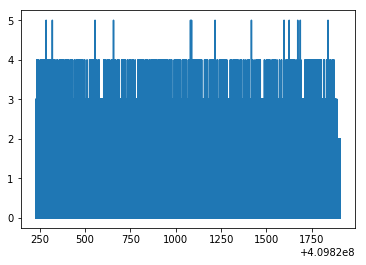

In [57]:
lc.plot()

Let's rebin our lightcurve too have a better look on the average flux per unit of time, In this case we are choosing 8 seconds as the new time resolution 

In [256]:
lc_rebin = lc.rebin(dt_new=8)

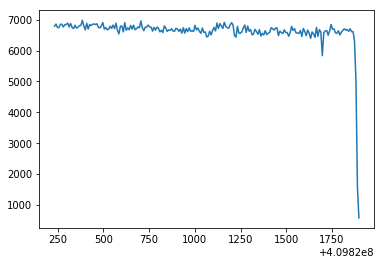

In [257]:
lc_rebin.plot()

Much better! the drop at the end is probably the detector being turned off. This should be clean by a well selected GTI (Good Time interval) but we will proceed as it is for this tutorial.

---

# 3 - Create Powerspectra with stingray

In [258]:
pds = stingray.AveragedPowerspectrum(lc, segment_size=16, norm="leahy")

(1, 3.5)

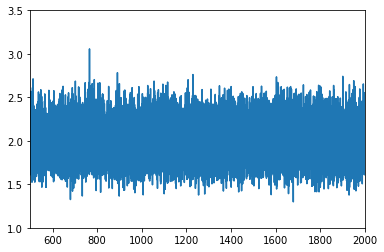

In [259]:
plt.plot(pds.freq, pds.power)
plt.xlim(500,2000)
plt.ylim(1, 3.5)

In [260]:
pds_rebin = pds.rebin(f=50)

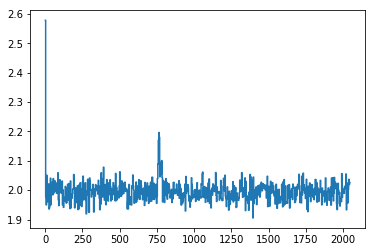

In [261]:
plt.plot(pds_rebin.freq, pds_rebin.power, linestyle="steps-mid")

(1.93, 2.2)

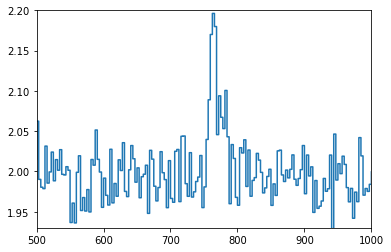

In [262]:
plt.plot(pds_rebin.freq, pds_rebin.power, linestyle="steps-mid")
plt.xlim(500, 1000)
plt.ylim(1.93, 2.2)

---

# 4 - Analysing the QPO frequency with a Dynamical Powerspectrum

In [263]:
dys = stingray.DynamicalPowerspectrum(lc, segment_size=16, norm="leahy")

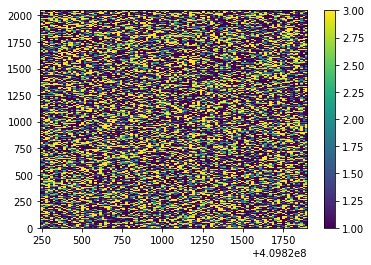

In [264]:
plt.imshow(dys.dyn_ps, aspect="auto", vmin=1, vmax=3, origin="lower",
          extent=[min(dys.time), max(dys.time), min(dys.freq), max(dys.freq)])
plt.colorbar()

In [266]:
dys.rebin_frequency(df_new=5, method="mean")

(600, 900)

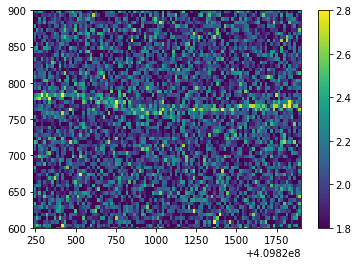

In [267]:
plt.imshow(dys.dyn_ps, aspect="auto", vmin=1.8, vmax=2.8, origin="lower",
           extent=[min(dys.time), max(dys.time), min(dys.freq), max(dys.freq)])
plt.colorbar()
plt.ylim(600,900)

In [268]:
dys.rebin_time(dt_new=dys.dt*3, method="mean")

(600, 900)

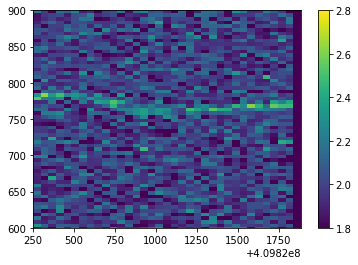

In [269]:
plt.imshow(dys.dyn_ps, aspect="auto", vmin=1.8, vmax=2.8, origin="lower",
          extent=[min(dys.time), max(dys.time), min(dys.freq), max(dys.freq)])
plt.colorbar()
plt.ylim(600,900)

We can use the method `trace_maximum` to find the frequency bin on which the power is maximum.
Noticed that for this method to work well you must rebin the dynspec and choose the frequency ranges very well, otherwise a spurious spike in you powerspectra will be detected instead of the acutal QPO signal

In [274]:
pos = dys.trace_maximum(min_freq=750, max_freq=790)

In [275]:
dys.freq[pos]

array([777.53125, 782.53125, 782.53125, 782.53125, 782.53125, 782.53125,
       782.53125, 777.53125, 772.53125, 772.53125, 772.53125, 772.53125,
       762.53125, 757.53125, 757.53125, 757.53125, 762.53125, 762.53125,
       752.53125, 767.53125, 762.53125, 762.53125, 767.53125, 762.53125,
       762.53125, 762.53125, 767.53125, 767.53125, 767.53125, 767.53125,
       762.53125, 767.53125, 767.53125, 767.53125, 762.53125])

(700, 900)

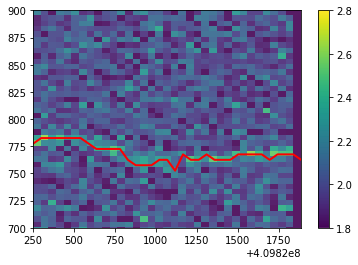

In [276]:
plt.imshow(dys.dyn_ps, aspect="auto", vmin=1.8, vmax=2.8, origin="lower",
          extent=[min(dys.time), max(dys.time), min(dys.freq), max(dys.freq)],
          alpha=0.9)
plt.colorbar()
plt.plot(dys.time, dys.freq[pos], 'r', lw=2)
plt.ylim(700,900)

---

# 5 - Fitting the QPO

Let's fit the QPO we found on the first rebinned averaged power spectrum:

(1.93, 2.2)

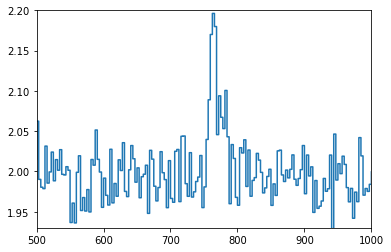

In [278]:
plt.plot(pds_rebin.freq, pds_rebin.power, linestyle="steps-mid")
plt.xlim(500, 1000)
plt.ylim(1.93, 2.2)

We use singray's modelling module and a convenience functio `fit_lorentzians`


In [315]:
import stingray.modeling as sting_model

In [316]:
parest, res = sting_model.fit_lorentzians(pds_rebin, 1, [amplitude, frequency, fwhm, noise],
                                          fit_whitenoise=True,)

In [317]:
res.p_opt

array([2.11064839e-01, 7.64674179e+02, 1.19873073e+01, 1.99312465e+00])

(1.93, 2.3)

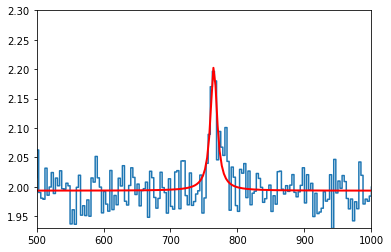

In [318]:
plt.plot(pds_rebin.freq, pds_rebin.power, linestyle="steps-mid")
plt.plot(pds_rebin.freq, res.model(pds_rebin.freq), "r", lw=2)
plt.xlim(500, 1000)
plt.ylim(1.93, 2.3)

The Best-fit parameters and uncertainties can be accesssed by `res.p_opt` and `res.err`

In [321]:
res.p_opt

array([2.11064839e-01, 7.64674179e+02, 1.19873073e+01, 1.99312465e+00])

In [322]:
res.err

array([4.27725103e+00, 4.85461768e+01, 1.88122205e+02, 1.86561630e-02])

In [323]:
for i,par in enumerate(res.model.param_names):
    print("{} = {:.2f} +- {:.2f}".format(par, res.p_opt[i], res.err[i]))

amplitude_0 = 0.21 +- 4.28
x_0_0 = 764.67 +- 48.55
fwhm_0 = 11.99 +- 188.12
amplitude_1 = 1.99 +- 0.02


---